In [1]:
include("src/NetworkEpistemology.jl")
using .NetworkEpistemology

In [2]:
using StatsPlots, LightGraphs, Printf, Distributions, DataFrames, IterableTables, EzXML, GraphIO

In [3]:
struct TransientDiversityStepStats
    agree::Bool
    fractionCorrect::Rational{Int16}
    totalBeliefChange::Float64
end

function evaluate_step(cur::TransientDiversityModelState, prev::TransientDiversityModelState)::TransientDiversityStepStats
    correct_action = argmax(cur.facts.actionProbabilities)

    number_correct = 0
    total_change = 0.0
    for i in 1:length(cur.individuals)
        if select_fact_to_observe(cur.individuals[i]) == correct_action
            number_correct += 1
        end
        total_change += sum(
            abs.(expectations(cur.individuals[i].beliefs) .- expectations(prev.individuals[i].beliefs))
        )
    end
    fraction = number_correct // length(cur.individuals)

    return TransientDiversityStepStats(
        fraction == 1,
        fraction,
        total_change
    )
end

function should_stop(stats::TransientDiversityStepStats)::Bool
    return false
end

@gen_test_fixture TransientDiversityModelState TransientDiversityStepStats TransientDiversity

@gen_df_helper TransientDiversityStepStats TransientDiversityExperimentSpec agree

@gen_df_helper TransientDiversityStepStats TransientDiversityExperimentSpec fractionCorrect

@gen_df_helper TransientDiversityStepStats TransientDiversityExperimentSpec totalBeliefChange

totalBeliefChange_by_run_df (generic function with 1 method)

In [4]:
cycle_params = [TransientDiversityModelState(cycle_digraph(i), 1000, [0.5, 0.499], Uniform(0, 4), Uniform(0, 4)) for i in 4:12]

complete_params = [
    TransientDiversityModelState(complete_digraph(i), 1000, [0.5, 0.499], Uniform(0, 4), Uniform(0, 4))
    for i in 3:11]

wheel_params = [
    TransientDiversityModelState(
        wheel_digraph(i), 1000, [0.5, 0.499], Uniform(0, 4), Uniform(0, 4))
    for i in 4:12]


9-element Array{ModelState{SimpleDiGraph,BinomialActionFacts,Main.NetworkEpistemology.Individuals.MyopicIndividual{BetaBeliefs}},1}:
 ModelState{SimpleDiGraph,BinomialActionFacts,Main.NetworkEpistemology.Individuals.MyopicIndividual{BetaBeliefs}}({4, 6} directed simple Int64 graph, BinomialActionFacts([0.5, 0.499], Binomial[Binomial{Float64}(n=1000, p=0.5), Binomial{Float64}(n=1000, p=0.499)], 1000), Main.NetworkEpistemology.Individuals.MyopicIndividual{BetaBeliefs}[Main.NetworkEpistemology.Individuals.MyopicIndividual{BetaBeliefs}(BetaBeliefs([1.422030199695822, 1.0010396577739726], [0.9774406560011135, 3.8111072902253387])), Main.NetworkEpistemology.Individuals.MyopicIndividual{BetaBeliefs}(BetaBeliefs([0.6650885151801429, 3.702072391818061], [1.428571643745527, 2.862049831737921])), Main.NetworkEpistemology.Individuals.MyopicIndividual{BetaBeliefs}(BetaBeliefs([1.2073708705379547, 3.0481797244882145], [0.4800128020298544, 1.7245760571438309])), Main.NetworkEpistemology.Individuals.M

In [91]:
cycle_spec = TransientDiversityExperimentSpec(
    TransientDiversityModelState(SimpleDiGraph(cycle_graph(500)), 1000, [0.5, 0.499], Uniform(0, 4), Uniform(0, 4)),
    10000,
    100,
    100
)
cycle_results = run_experiment(cycle_spec)
mean([res.agree for res in cycle_results[:,end]])


1.0

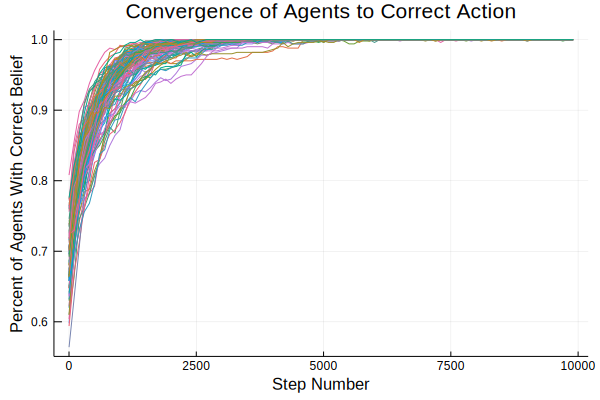

In [124]:
@df fractionCorrect_by_run_df(cycle_results, cycle_spec) plot(:StepNumber, cols(2:100),
    xlabel = "Step Number",
    ylabel = "Percent of Agents With Correct Belief",
    title = "Convergence of Agents to Correct Action",
    label = "")

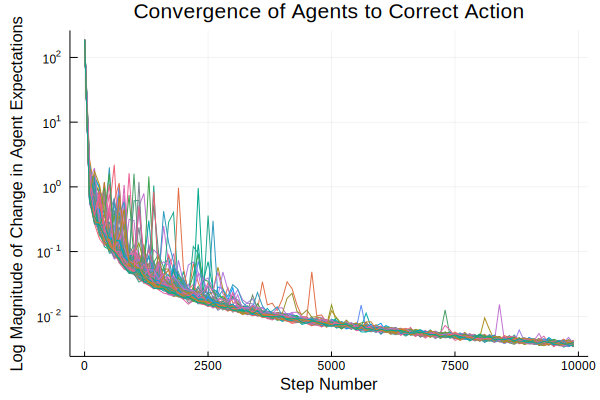

In [121]:
@df totalBeliefChange_by_run_df(cycle_results, cycle_spec) plot(:StepNumber, cols(2:100),
    xlabel = "Step Number",
    ylabel = "Log Magnitude of Change in Agent Expectations",
    yscale = :log10,
    title = "Convergence of Agents to Correct Action",
    label = "")

In [88]:
g = loadgraph("social_epistemology.graphml", "digraph", GraphIO.GraphML.GraphMLFormat())

{799, 1999} directed simple Int64 graph

In [125]:
social_spec = TransientDiversityExperimentSpec(
    TransientDiversityModelState(g, 1000, [0.5, 0.499], Uniform(0, 4), Uniform(0, 4)),
    10000,
    100,
    100
)
social_results = run_experiment(social_spec)
mean([res.agree for res in social_results[:,end]])


0.0

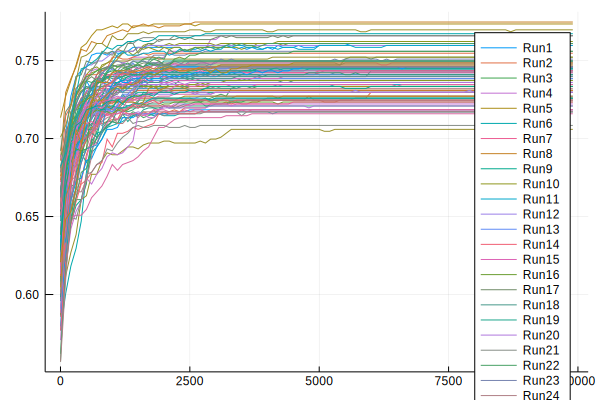

In [126]:
@df fractionCorrect_by_run_df(social_results, social_spec) plot(:StepNumber, cols(2:100))

In [127]:
ug = union(reverse(g), g)

{799, 3589} directed simple Int64 graph

In [128]:
social_spec_ud = TransientDiversityExperimentSpec(
    TransientDiversityModelState(g, 1000, [0.5, 0.499], Uniform(0, 4), Uniform(0, 4)),
    10000,
    100,
    100
)
social_results_ud = run_experiment(social_spec_ud)
mean([res.agree for res in social_results_ud[:,end]])


0.0

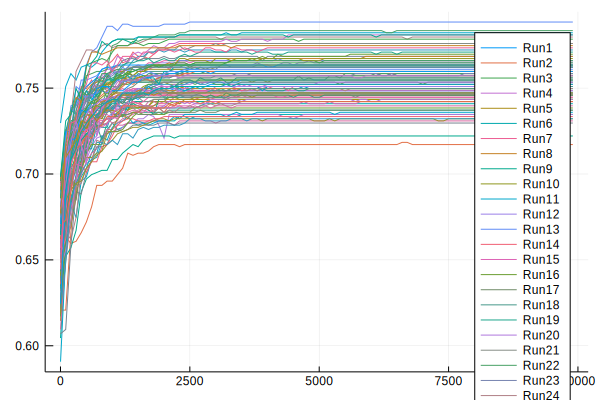

In [129]:
@df fractionCorrect_by_run_df(social_results_ud, social_spec_ud) plot(:StepNumber, cols(2:100))